In [6]:
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fractal.loaders.hyperliquid import HyperliquidFundingRatesLoader
from fractal.loaders.binance import BinancePriceLoader
from fractal.loaders.base_loader import LoaderType
from fractal.core.base import Observation
from fractal.core.entities import UniswapV3LPGlobalState, HyperLiquidGlobalState
from fractal.strategies.basis_trading_strategy import BasisTradingStrategyHyperparams
from fractal.strategies.hyperliquid_basis import HyperliquidBasis

from dataclasses import dataclass

In [59]:
TICKER = 'BTC'
FREQUENCY = '4h'  # период агрегации данных

@dataclass
class HyperliquidBasisParams(BasisTradingStrategyHyperparams):
    """
    Параметры стратегии HyperliquidBasis.
    """
    EXECUTION_COST: float

# Гиперпараметры стратегии
STRAT_PARAMS = HyperliquidBasisParams(
    MIN_LEVERAGE=1,
    TARGET_LEVERAGE=3,
    MAX_LEVERAGE=10,
    INITIAL_BALANCE=1_000_000,
    EXECUTION_COST=0.002  # 0.2% стоимость исполнения ордера
)

HyperliquidBasis.MAX_LEVERAGE = STRAT_PARAMS.MAX_LEVERAGE

# Параметры backtest-periods
PERIODS = {
    'bull': {
        'start': datetime(2023, 1, 1, tzinfo=timezone.utc),
        'end':   datetime(2025, 1, 1, tzinfo=timezone.utc)
    },
    'bear': {
        'start': datetime(2025, 1, 1, tzinfo=timezone.utc),
        'end':   datetime(2025,5, 1, tzinfo=timezone.utc)
    }
}

In [ ]:
def load_and_clean_data(ticker: str, start: datetime, end: datetime, freq: str) -> pd.DataFrame:
    # Funding rates
    rates = HyperliquidFundingRatesLoader(
        ticker, start_time=start, end_time=end
    ).read(with_run=True)
    rates = rates.resample(freq).sum()

    # Perp prices (USDT)
    prices = BinancePriceLoader(
        ticker + 'USDT', interval=freq,
        loader_type=LoaderType.CSV,
        start_time=start, end_time=end
    ).read(with_run=True)

    # Совмещение
    df = prices.join(rates, how='outer')
    df['rate'].fillna(0, inplace=True)
    df['price'].interpolate(method='time', inplace=True)
    df['rate'].interpolate(method='time', inplace=True)

    # Удаление выбросов: Z-score по цене
    z = (df['price'] - df['price'].mean()) / df['price'].std()
    df = df[np.abs(z) < 5]
    df.dropna(inplace=True)
    return df

In [ ]:
def build_observations(df: pd.DataFrame) -> list[Observation]:
    observations = []
    for ts, row in df.iterrows():
        observations.append(
            Observation(
                timestamp=ts,
                states={
                    'SPOT': UniswapV3LPGlobalState(
                        price=row.price, tvl=0, volume=0, fees=0, liquidity=0
                    ),
                    'HEDGE': HyperLiquidGlobalState(
                        mark_price=row.price, funding_rate=row.rate
                    )
                }
            )
        )
    return observations

In [ ]:
def run_backtest(period_name: str, params: HyperliquidBasisParams, freq: str):
    start = PERIODS[period_name]['start']
    end   = PERIODS[period_name]['end']
    print(f"Loading data for {period_name} period: {start.date()} to {end.date()}")

    df = load_and_clean_data(TICKER, start, end, freq)
    observations = build_observations(df)

    strategy = HyperliquidBasis(debug=False, params=params)
    result = strategy.run(observations)
    metrics = result.get_default_metrics()
    return result, metrics

In [ ]:
results = {}
metrics = {}
for regime in PERIODS:
    res, mets = run_backtest(regime, STRAT_PARAMS, FREQUENCY)
    results[regime] = res
    metrics[regime] = mets

Loading data for bull period: 2023-01-01 to 2025-01-01


C:\Users\Никита\AppData\Local\Temp\ipykernel_20048\1951817775.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rate'].fillna(0, inplace=True)
C:\Users\Никита\AppData\Local\Temp\ipykernel_20048\1951817775.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

Loading data for bear period: 2025-01-01 to 2025-05-01


C:\Users\Никита\AppData\Local\Temp\ipykernel_20048\1951817775.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rate'].fillna(0, inplace=True)
C:\Users\Никита\AppData\Local\Temp\ipykernel_20048\1951817775.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [ ]:
initial_balance = STRAT_PARAMS.INITIAL_BALANCE  

for regime in PERIODS:
    print(f"\n--- Metrics for {regime} period ---")
    result = results[regime]     
    mets   = metrics[regime]     

    df = result.to_dataframe()
    equity = df['net_balance']

    returns = equity.pct_change().dropna()
    annualisation = np.sqrt(6 * 365)
    vol = returns.std() * annualisation

    net_pnl = initial_balance * mets.accumulated_return

    print(f"Net PnL:         {net_pnl:.2f}")
    print(f"Annual Return:   {mets.apy * 100:.2f}%")
    print(f"Volatility:      {vol * 100:.2f}%")
    print(f"Sharpe:          {mets.sharpe:.2f}")
    print(f"Max Drawdown:    {mets.max_drawdown * 100:.2f}%")


--- Metrics for bull period ---
Net PnL:         279913.64
Annual Return:   13.98%
Volatility:      0.46%
Sharpe:          26.83
Max Drawdown:    -0.85%

--- Metrics for bear period ---
Net PnL:         22460.42
Annual Return:   6.84%
Volatility:      0.21%
Sharpe:          31.85
Max Drawdown:    -0.10%


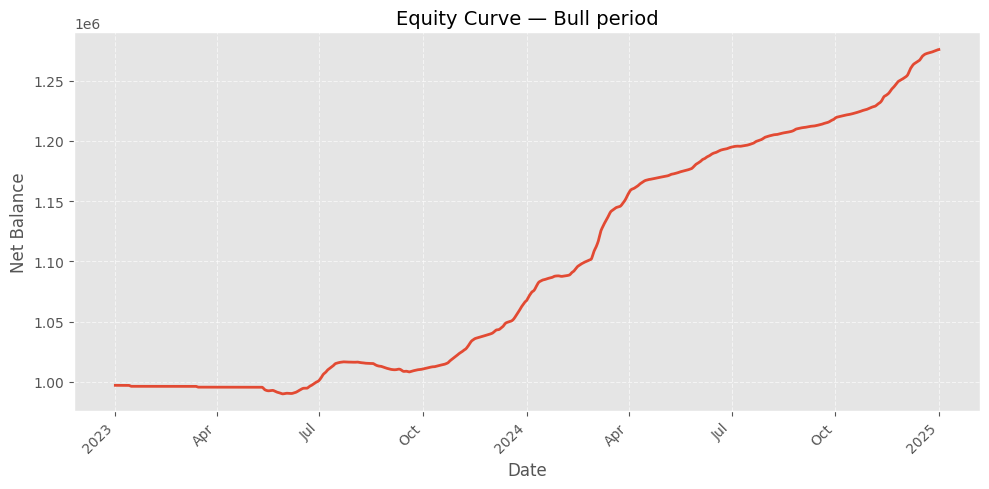

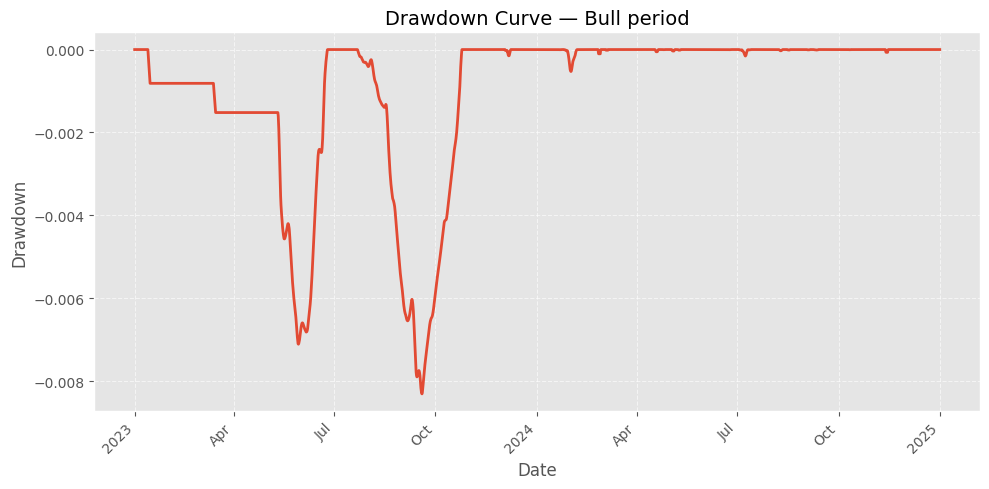

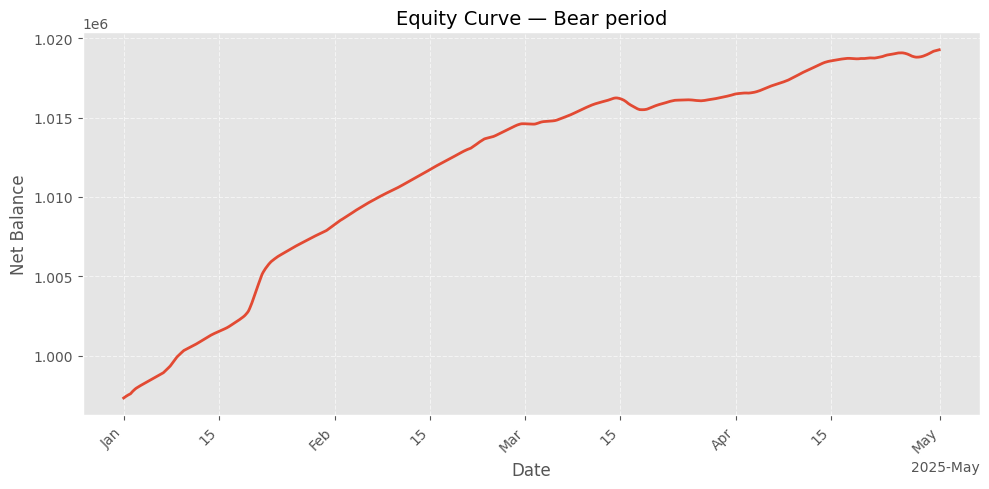

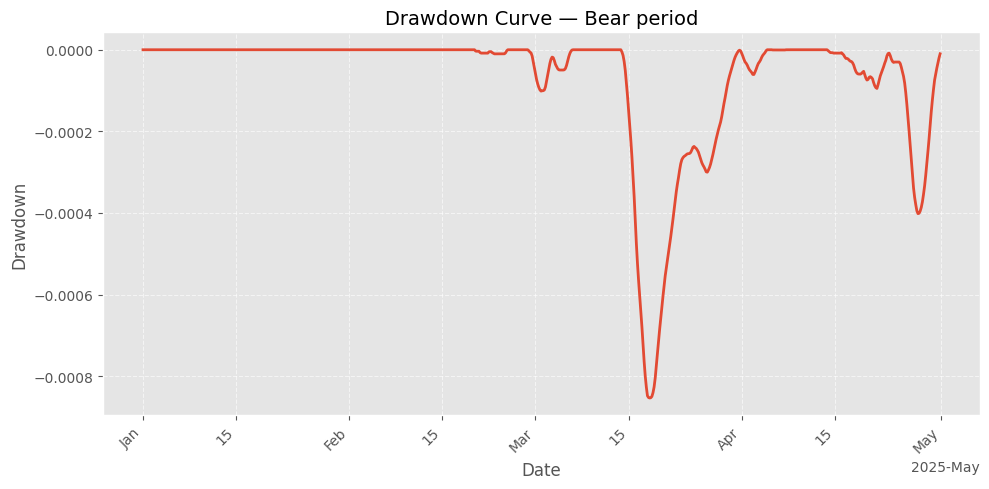

Saved plots:
- fig/bull_equity_curve.png
- fig/bull_drawdown_curve.png
- fig/bear_equity_curve.png
- fig/bear_drawdown_curve.png


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

os.makedirs('fig', exist_ok=True)

plt.style.use('ggplot')
locator   = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
smoothing_window = 12  # ~48 часов

for regime, result in results.items():
    df = result.to_dataframe().copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df.set_index('timestamp', inplace=True)
    equity = df['net_balance']
    smoothed_equity = equity.rolling(window=smoothing_window, min_periods=1, center=True).mean()
    
    # Equity Curve
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(smoothed_equity.index, smoothed_equity.values, linewidth=2)
    ax.set_title(f'Equity Curve — {regime.capitalize()} period', fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Balance', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    path_eq = f'fig/{regime}_equity_curve.png'
    fig.savefig(path_eq, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    # Drawdown Curve
    cum_max = equity.cummax()
    drawdown = (equity - cum_max) / cum_max
    smoothed_drawdown = drawdown.rolling(window=smoothing_window, min_periods=1, center=True).mean()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(smoothed_drawdown.index, smoothed_drawdown.values, linewidth=2)
    ax.set_title(f'Drawdown Curve — {regime.capitalize()} period', fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Drawdown', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    path_dd = f'fig/{regime}_drawdown_curve.png'
    fig.savefig(path_dd, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)